In [2]:
from datasets import load_dataset
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy.scorer import Scorer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm
from torch.optim import AdamW
import pickle
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix 
import seaborn as sns 
import math

from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

2023-12-21 09:41:44.205073: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-21 09:41:45.314571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 09:41:45.314618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 09:41:45.345300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 09:41:46.080040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-21 09:41:46.093145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
def process_text(text, use_lemmatization=True):
    ''' Process the text: lowercasing, lemmatization, stopwords removal, 
        and punctuation removal
        Input: text: the text to be processed'''
    text = text.lower()
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('  ', ' ')

    # Word tokenization 
    tokens = word_tokenize(text)

    # Normalization (lowercasing and lemmatization)
    if(use_lemmatization):
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Token filtering (stopwords removal)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalpha()]

    # Join the tokens back into a string
    text = ' '.join(tokens)

    return text

In [4]:
def plot_classes_distribution(labels, num_samples_per_class, title):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.barh(labels, num_samples_per_class)
    plt.xlabel("Number of samples")
    plt.ylabel("Class")
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

In [5]:
def basic_statistics(dataset):
    num_samples = len(dataset['train']) 
    
    # Number of classes
    labels = []
    for sample in dataset['train']['prediction']:
        label = sample[0]['label']
        if label not in labels:
            labels.append(label)
    
    num_classes = len(labels)
    num_samples_per_class=[]
    for label in labels:
        num_samples_per_class.append(len(dataset['train'].filter(lambda example: example['prediction'][0]['label'] == label)))

    return num_samples, labels, num_classes, num_samples_per_class

In [6]:
# Load the dataset
dataset = load_dataset("argilla/medical-domain")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4966 [00:00<?, ? examples/s]

as a recap from exericse one, let's have a look again at the classes

In [7]:
num_samples, labels, num_classes, num_samples_per_class = basic_statistics(dataset)

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

In [8]:
print("Number of samples: ", num_samples)
print("Number of classes: ", num_classes)

Number of samples:  4966
Number of classes:  40


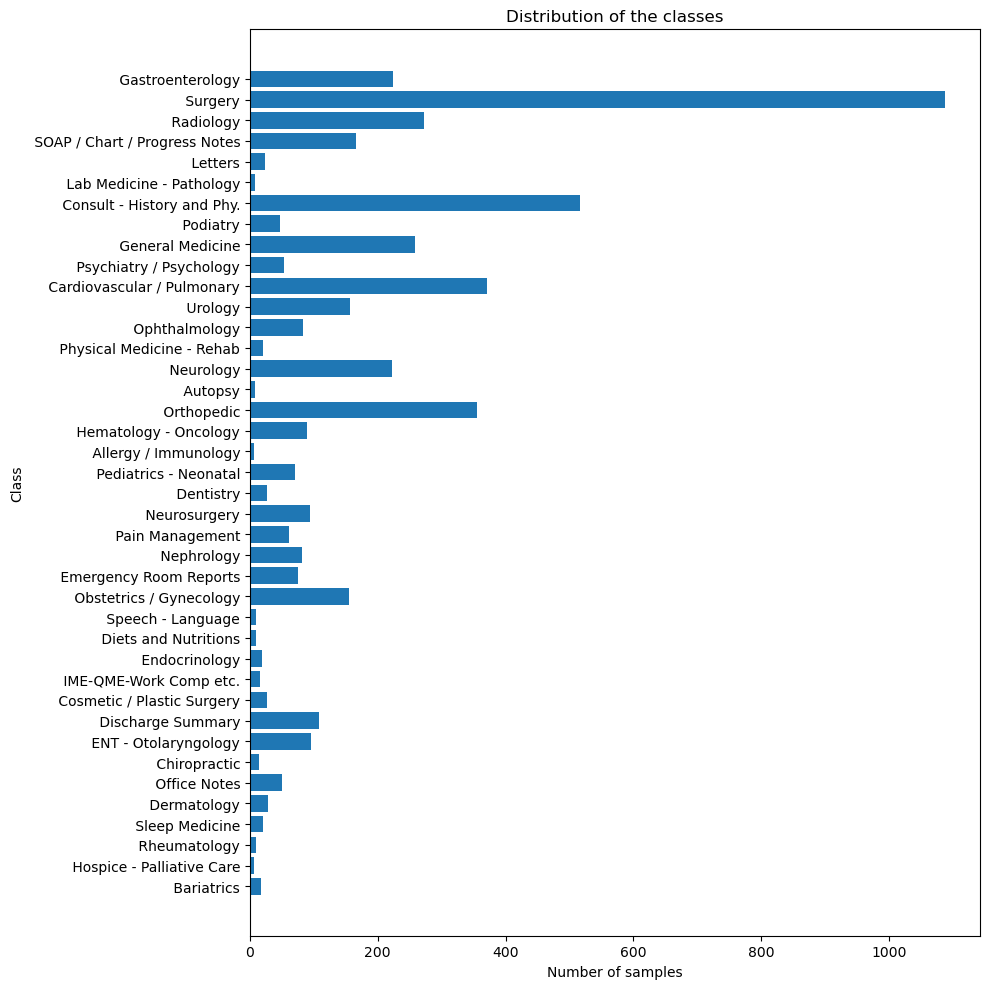

In [9]:
# plot the distribution of the classes
plot_classes_distribution(labels, num_samples_per_class, "Distribution of the classes")

In [10]:
#Filter classes which are too small
min_num_samples=0 # no filtering
filtered_classes = np.array(labels)[np.array(num_samples_per_class)>min_num_samples]
dataset['train'] = dataset['train'].filter(lambda sample: sample['prediction'][0]['label'] in filtered_classes)

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4966 [00:00<?, ? examples/s]

Number of samples after filtering:  4966
Number of classes after filtering:  40


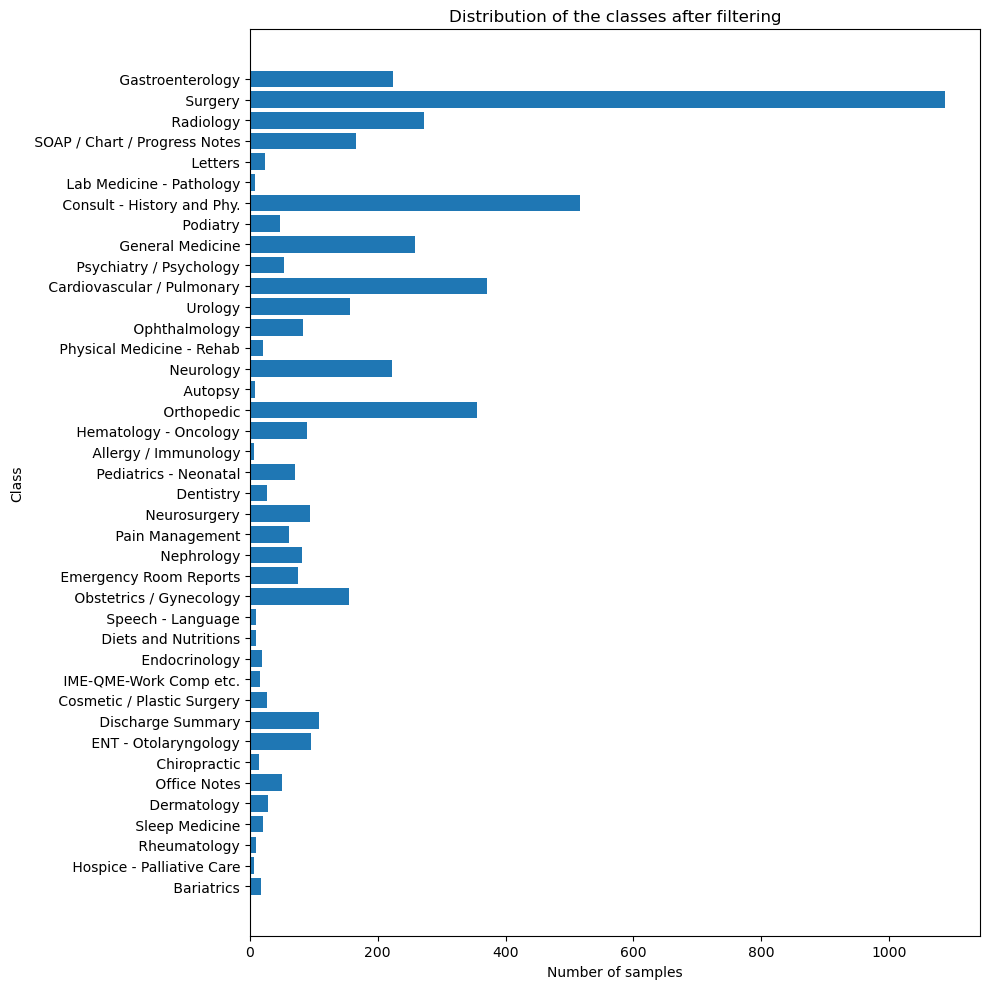

In [11]:
#show statistics again
num_samples, labels, num_classes, num_samples_per_class = basic_statistics(dataset)
print("Number of samples after filtering: ", num_samples)
print("Number of classes after filtering: ", num_classes)
# plot the distribution of the classes after filtering
plot_classes_distribution(labels, num_samples_per_class, "Distribution of the classes after filtering")

Next we are going to set the environment that we created in Task 1 for the preprocessing of the text using the pipeline provided in our Task 1 notebook. 

In [12]:
# preprocess the data
use_preprocessing=True
dataset_p = pd.DataFrame(columns=['tokens', 'label'])
for i in range(len(dataset['train'])):
    text = dataset['train'][i]['text']
    label = dataset['train'][i]['prediction'][0]['label']
    if(use_preprocessing):
        text = process_text(text)
    dataset_p.loc[i] = [text, label]

In [13]:
dataset_p.head()

,tokens,label
0,preoperative diagnosis iron deficiency postope...,Gastroenterology
1,clinical indication normal stress procedure pe...,Surgery
2,finding scan performed reformatted image obtai...,Radiology
3,preoperative diagnosis blood loss postoperativ...,Surgery
4,reason visit elevated psa nocturia occasional ...,SOAP / Chart / Progress Notes


In [14]:
#convert labels to numbers
label2idx = {}
idx2label = {}
for i, label in enumerate(dataset_p['label'].unique()):
    label2idx[label] = i
    idx2label[i] = label

dataset_p['label'] = dataset_p['label'].map(label2idx)
dataset_p.head()


,tokens,label
0,preoperative diagnosis iron deficiency postope...,0
1,clinical indication normal stress procedure pe...,1
2,finding scan performed reformatted image obtai...,2
3,preoperative diagnosis blood loss postoperativ...,1
4,reason visit elevated psa nocturia occasional ...,3


In [15]:
#how many labels are there
print(len(dataset_p['label'].unique()))
dataset_p['label'].value_counts().sort_index()

40


label
0      224
1     1088
2      273
3      166
4       23
5        8
6      516
7       47
8      259
9       53
10     371
11     156
12      83
13      21
14     223
15       8
16     355
17      90
18       7
19      70
20      27
21      94
22      61
23      81
24      75
25     155
26       9
27      10
28      19
29      16
30      27
31     108
32      96
33      14
34      50
35      29
36      20
37      10
38       6
39      18
Name: count, dtype: int64

In [16]:
#we want to use clinicalBERT for classification -> use its tokenizer
tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
## playing around with the tokenization
# apply tokenize on a sample and check the output
sample = dataset_p["tokens"][0]

print("Sample text before tokenization: ", sample)
tokens = process_text(sample)
print(tokens)
sample = tokenizer.encode(sample)
print("Sample text after tokenization: ", tokenizer.convert_ids_to_tokens(sample))

Sample text before tokenization:  preoperative diagnosis iron deficiency postoperative diagnosis procedure medication procedure olympus pediatric variable colonoscope wa introduced rectum advanced carefully colon cecum identified ileocecal valve appendiceal orifice preparation wa good although wa residual material cecum wa difficult clear completely mucosa wa normal throughout colon polyp lesion identified blood wa noted diverticulum seen sigmoid colon luminal narrowing evidence inflammation retroflex view anorectal junction showed hemorrhoid patient tolerated procedure well wa sent recovery final diagnosis diverticulosis otherwise normal colonoscopy recommendation follow x screening colonoscopy additional evaluation cause anemia may appropriate
preoperative diagnosis iron deficiency postoperative diagnosis procedure medication procedure olympus pediatric variable colonoscope wa introduced rectum advanced carefully colon cecum identified ileocecal valve appendiceal orifice preparation 

In [18]:
# Function to return the length of tokenized text
def count_tokens_bert(text):
    return len(tokenizer.encode(text))


def count_tokens(text):
    return len(text.split())


# Apply the function to each row and find the maximum length
token_lengths = dataset_p["tokens"].apply(count_tokens)
max_token_length = max(token_lengths)

print("Maximum number of tokens in a single row:", max_token_length)
# how many tokens have lenght > 512
nb_too_long_tokens = token_lengths[token_lengths > 512].count() / len(token_lengths)
print("Percentage of tokens which have token length > 512: ", nb_too_long_tokens)

Maximum number of tokens in a single row: 1636
Percentage of tokens which have token length > 512:  0.09021345146999597


the max nb of tokens that BERT can take is 512, so these entry will be truncated to 512 tokens

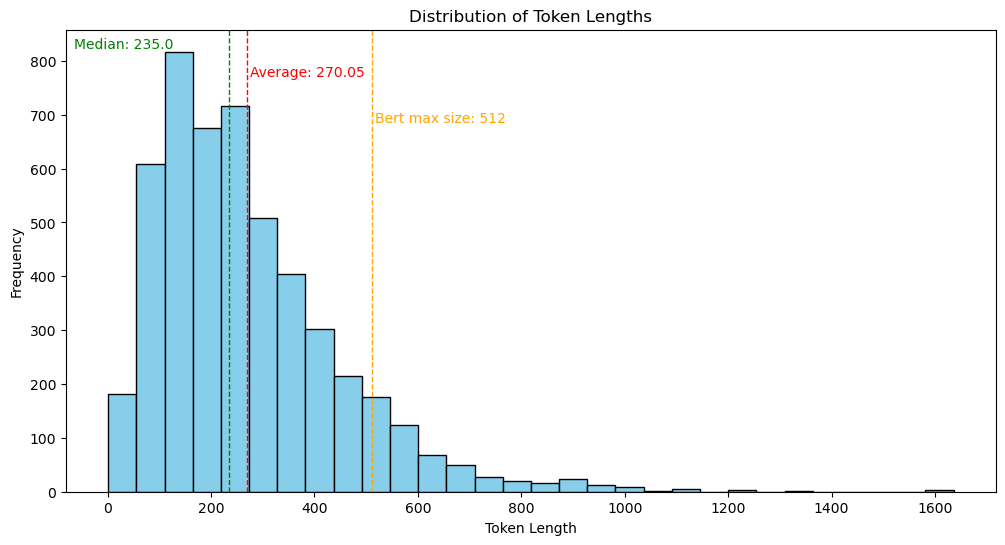

In [19]:
average_token_length = token_lengths.mean()
median_token_length = token_lengths.median()
bert_max_size = 512

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(average_token_length, color="red", linestyle="dashed", linewidth=1)
plt.axvline(median_token_length, color="green", linestyle="dashed", linewidth=1)
plt.axvline(bert_max_size, color="orange", linestyle="dashed", linewidth=1)
plt.title("Distribution of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.text(
    average_token_length + 5,
    plt.ylim()[1] * 0.9,
    f"Average: {average_token_length:.2f}",
    color="red",
)
plt.text(
    median_token_length - 300,
    plt.ylim()[1] * 0.96,
    f"Median: {median_token_length}",
    color="green",
)
plt.text(
    bert_max_size + 5,
    plt.ylim()[1] * 0.8,
    f"Bert max size: {bert_max_size}",
    color="orange",
)

plt.show()

In [20]:
# split rows that have more than 512 tokens into multiple rows to not lose data
def split_text(text, max_length):
    # Tokenize the text into words (not BERT tokens)
    words = text.split()

    #num of chunks
    num_of_chunks = math.ceil(len(words)/max_length)
    chunk_length = len(words) // num_of_chunks
    
    # Split words into chunks of chunk_length
    chunks = [
        " ".join(words[i : i + max_length]) for i in range(0, len(words), chunk_length)
    ]
    
    return chunks

In [21]:
train_df, eval_df = train_test_split(dataset_p, test_size=0.2, stratify=torch.tensor(dataset_p["label"].values))

In [22]:
max_length = 512 - 2  # accounting for [CLS] and [SEP]

new_rows_train = []
for _, row in train_df.iterrows():
    text_chunks = split_text(row["tokens"], max_length)
    for chunk in text_chunks:
        new_rows_train.append({"tokens": chunk, "label": row["label"]})
train_df = pd.DataFrame(new_rows_train)

new_rows_eval = []
for _, row in eval_df.iterrows():
    text_chunks = split_text(row["tokens"], max_length)
    for chunk in text_chunks:
        new_rows_eval.append({"tokens": chunk, "label": row["label"]})
eval_df = pd.DataFrame(new_rows_eval)

In [23]:
def tokenize(sent):
    encoded = tokenizer.encode_plus(
        text=sent,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_attention_mask=True,
        return_tensors="pt",
    )
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
    }

In [24]:
train_labels = torch.tensor(train_df["label"].values)
eval_labels = torch.tensor(eval_df["label"].values)
#get a weight per sample based on the label: label_weight = 1/ (num_classes * num_samples_per_class[class_label])
weight_samples=1/(torch.index_select(torch.tensor(num_samples_per_class),0,train_labels)*num_classes) 

### Training with machine learning algorithms

In [25]:
def evaluate(eval_labels, predictions): 
    accuracy = accuracy_score(eval_labels, predictions)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        eval_labels, predictions, average="macro"
    )
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        eval_labels, predictions, average="micro"
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        eval_labels, predictions, average="weighted"
    )
    
    return {"accuracy": accuracy, "precision_macro": precision_macro, "recall_macro": recall_macro, "f1_macro": f1_macro, "precision_micro": precision_micro, "recall_micro": recall_micro, "f1_micro": f1_micro, "precision_weighted": precision_weighted, "recall_weighted": recall_weighted, "f1_weighted": f1_weighted}

In [26]:
train_inputs=train_df["tokens"].values
eval_inputs=eval_df["tokens"].values

In [37]:
# Pipelining
tfidf = TfidfVectorizer(ngram_range=(1,2))
clf = MultinomialNB()
nb_tfidf = make_pipeline(tfidf, clf) 

In [38]:
parameters = { 
        'multinomialnb__alpha': [1,0.1,0.001],
        'tfidfvectorizer__min_df': [1,5,10,15,20,35,50,100]
    }
grid_search = GridSearchCV(nb_tfidf, parameters, scoring="f1_weighted", n_jobs=-1) # using f1_weighted because classes can't be balanced

In [ ]:
#No weighting possible
grid_search.fit(train_inputs, train_labels)
print("best params: " + str(grid_search.best_params_)) 
predictions = grid_search.predict(eval_inputs)
print("The Naive Bayes model has following scores: ")
print(evaluate(eval_labels, predictions)) 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [100]:
# Pipelining
tfidf = TfidfVectorizer(ngram_range=(1,2))
clf = RandomForestClassifier(class_weight="balanced", n_jobs=-1)
nb_tfidf = make_pipeline(tfidf, clf) 

In [ ]:
parameters = { 
        'randomforestclassifier__n_estimators': [50,100,150],
        'randomforestclassifier__max_depth': [None, 10, 20],
        'randomforestclassifier__min_samples_split': [2,5,10],
        'randomforestclassifier__max_features': ["sqrt", "log2"],
        'tfidfvectorizer__min_df': [1,5,10,15,20,35,50,100]
    }
grid_search = GridSearchCV(nb_tfidf, parameters, scoring="f1_macro", n_jobs=-1) 

hier muss ich was machen

In [101]:
grid_search.fit(train_inputs, train_labels)
print("best params: " + str(grid_search.best_params_)) 
predictions = grid_search.predict(eval_inputs)
print("The Random Forest model has following scores: ")
print(evaluate(eval_labels, predictions)) 

The Random Forest model has following scores: 
{'accuracy': 0.09122203098106713, 'precision_macro': 0.06765484599711581, 'recall_macro': 0.06639169217381753, 'f1_macro': 0.06475010544599004, 'precision_micro': 0.09122203098106713, 'recall_micro': 0.09122203098106713, 'f1_micro': 0.09122203098106713, 'precision_weighted': 0.09311971304886897, 'recall_weighted': 0.09122203098106713, 'f1_weighted': 0.09109260808733897}


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Pipelining
tfidf = TfidfVectorizer(ngram_range=(1,2))
clf = SVC(class_weight="balanced")
nb_tfidf = make_pipeline(tfidf, clf) 

In [ ]:
parameters = { 
        'svc__gamma': ["scale", "auto", 10, 1, 0.1, 0.01, 0.001],
        'svc__C': [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001], 
        'svc__kernel': ["linear", "poly", "rbf"], 
        'tfidfvectorizer__min_df': [1,5,10,15,20,35,50,100]
    }
grid_search = GridSearchCV(nb_tfidf, parameters, scoring="f1_macro", n_jobs=-1) 

In [ ]:
grid_search.fit(train_inputs, train_labels)
print("best params: " + str(grid_search.best_params_)) 
predictions = grid_search.predict(eval_inputs)
print("The SVC model has following scores: ")
print(evaluate(eval_labels, predictions)) 

### Training with BERT

In [23]:
train_encodings = train_df["tokens"].apply(lambda x: tokenize(x))
eval_encodings = eval_df["tokens"].apply(lambda x: tokenize(x))

train_inputs = torch.cat(
    train_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0
)
train_masks = torch.cat(
    train_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

eval_inputs = torch.cat(
    eval_encodings.apply(lambda x: x["input_ids"]).tolist(), dim=0
)
eval_masks = torch.cat(
    eval_encodings.apply(lambda x: x["attention_mask"]).tolist(), dim=0
)

In [24]:
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
eval_dataset = TensorDataset(eval_inputs, eval_masks, eval_labels)

train_sampler = WeightedRandomSampler(weight_samples, num_samples=train_labels.shape[0], replacement=True)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=4)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")	

In [26]:
model = AutoModelForSequenceClassification.from_pretrained(
    "medicalai/ClinicalBERT",
    num_labels=num_classes,
)
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at medicalai/ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [27]:
def evaluate(model, dataloader): 

    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = batch_labels.to("cpu").numpy()

            predictions.append(logits)
            true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    predictions = np.argmax(predictions, axis=1)

    data_to_save = {"true_labels": true_labels, "predictions": predictions}

    with open("model_evaluation_data_project_split_rows_with_pp.pkl", "wb") as file:
        pickle.dump(data_to_save, file)
    
    accuracy = accuracy_score(true_labels, predictions)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        true_labels, predictions, average="macro"
    )
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        true_labels, predictions, average="micro"
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        true_labels, predictions, average="weighted"
    )

    return {"accuracy": accuracy, "precision_macro": precision_macro, "recall_macro": recall_macro, "f1_macro": f1_macro, "precision_micro": precision_micro, "recall_micro": recall_micro, "f1_micro": f1_micro, "precision_weighted": precision_weighted, "recall_weighted": recall_weighted, "f1_weighted": f1_weighted}

In [28]:
num_epochs = 0
max_patience=10
patience = max_patience
best_f1 = 0
optimizer = AdamW(model.parameters(), lr=5e-7)
it = 0
# Create tensorboard
summary = SummaryWriter("./", purge_step=0)

epoch_length = len(train_dataloader)

from tqdm import tqdm

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}/{num_epochs}...")
    model.train()

    for batch in tqdm(train_dataloader):
        it += 1
        batch_inputs, batch_masks, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        #record training loss for tensorboard
        if (it % (epoch_length/8)) == 0:
            summary.add_scalar("training loss", loss.cpu().item(), it)  

    #evaluation after epoch
    model.eval()
    eval_metrics = evaluate(model, eval_dataloader)
    
    #record evaluation metrics for tensorboard
    for key in eval_metrics:
        summary.add_scalar(key, eval_metrics[key], epoch +1)

    #check if we reached new highscore
    f1 = eval_metrics['f1_micro']            
    if best_f1 < f1:
        patience = max_patience
        best_f1=f1
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience -= 1
    
    print(f"My remaining patience is {patience}.") 
    print(f"Current f1 score is {f1}")
    print(f"Current loss is {loss.cpu().item()}")
    
    #check for early stopping
    if patience <= 0:
        print("My patience run out.") 
        break
        
print("Training finished with " + str(num_epochs) + " epochs")  
            

Training finished with 0 epochs


### Training on Ubelix and saving best model

In [29]:
model.load_state_dict(torch.load("best_model.pt", map_location=torch.device('cpu')))
eval_metrics = evaluate(model, eval_dataloader)
print(
    f"Validation Results - Accuracy: {eval_metrics['accuracy']:.3f}, Precision: {eval_metrics['precision_micro']:.3f}, Recall: {eval_metrics['recall_micro']:.3f}, F1: {eval_metrics['f1_micro']:.3f}"
)

KeyboardInterrupt: 

copied from ubelix:

#### with preprocessing:

Validation Results - Accuracy: 0.336, Precision: 0.295, Recall: 0.336, F1: 0.303

#### without preprocessing (tokenization only):

Validation Results - Accuracy: 0.311, Precision: 0.266, Recall: 0.311, F1: 0.279

#### with preprocessing and splitting rows > 512 tokens:
Validation Results - Accuracy: 0.338, Precision: 0.290, Recall: 0.338, F1: 0.275

In [ ]:
# load predictions and true labels and plot
with open("model_evaluation_data_project.pkl", "rb") as handle:
    dict_pp = pickle.load(handle)

y_test_pp = dict_pp["true_labels"]
preds_pp = dict_pp["predictions"]
print(dict_pp.keys())

In [ ]:
with open("model_evaluation_data_project_tokenizer_only.pkl", "rb") as handle:
    dict_nopp = pickle.load(handle)

##compare to model without preprocessing
y_test_nopp = dict_nopp["true_labels"]
preds_nopp = dict_nopp["predictions"]



In [ ]:
with open("model_evaluation_data_project_split_rows.pkl", "rb") as handle:
    dict_split = pickle.load(handle)

##compare to model without preprocessing
y_test_split = dict_split["true_labels"]
preds_split = dict_split["predictions"]

In [ ]:
with open("model_evaluation_data_project_split_rows_no_pp.pkl", "rb") as handle:
    dict_split_pp = pickle.load(handle)

##compare to model without preprocessing
y_test_split_npp = dict_split_pp["true_labels"]
preds_split_npp = dict_split_pp["predictions"]

In [ ]:
with open("model_evaluation_data_project_split_rows_with_pp.pkl", "rb") as handle:
    dict_split_pp = pickle.load(handle)

##compare to model without preprocessing
y_test_split_pp = dict_split_pp["true_labels"]
preds_split_pp = dict_split_pp["predictions"]

In [ ]:
labels= dataset_p['label'].unique().tolist()
labels

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_pp, preds_pp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Normalized Confusion Matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
cm = confusion_matrix(y_test_nopp, preds_nopp)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix without preprocessing")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_split, preds_split)

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix with preprocessing and splitting texts")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

confusion matrix without the splitting looks better to me. here it seems that the model learnt that there are many surgery cases and no mostly predicts surgery, independent of the actual label.


TODO: how to deal with class imbalance?

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_split_npp, preds_split_npp)
#cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d", #.2f, d
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix without preprocessing, but splitting texts")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
# Assuming true_labels and predictions are your labels and predictions
cm = confusion_matrix(y_test_split_pp, preds_split_pp)
#cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt="d", #.2f, d
    cmap="Blues",
    xticklabels=idx2label.values(),
    yticklabels=idx2label.values(),
)
plt.title("Confusion Matrix without preprocessing, but splitting texts")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()